In [2]:
import sys
sys.path.append('/home/ABTLUS/victor.secco/data_processing') 
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import hyperspy.api as hs
import cv2
from mypackages.edp_processing import ImageAnalysis, ImageProcessing
import gc

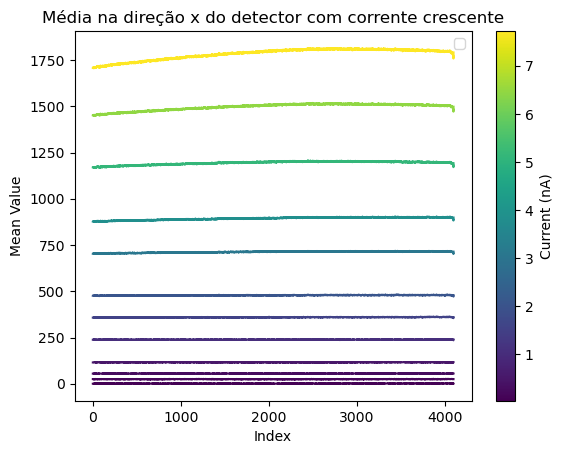

In [3]:
# Cálculo da linearidade do detector CCD Ceta-S do Titan ----
directory = '/home/ABTLUS/victor.secco/data_processing/ED_data/Gain/Linearity/npy_files'
files= [x for x in os.listdir(directory)]
files.sort(key = lambda x: x.split('_')[3])
currents_string = [x.split("_")[3] for x in files if x.endswith('_2_1_mean.npy') ] 
mean_arrays=[]
white_images = []

from matplotlib.cm import viridis
from matplotlib.colors import Normalize
# Loop through each file in the directory
for filename in files:
    if filename.endswith('_2_1_mean.npy'):
        file_path = os.path.join(directory, filename)
        
        # Load the npy file
        data = np.load(file_path)

        white_images.append(data)
        
        # Calculate the mean along axis 0
        mean_data = np.mean(data, axis=0)
        
        # Append the mean array to the list
        mean_arrays.append(mean_data)
        #print(f"Processed {filename}")

currents = [float(c.replace('nA', '')) for c in currents_string]

# Normalize these currents for color mapping
norm = Normalize(vmin=min(currents), vmax=max(currents))
colors = viridis(norm(currents))


# Create a figure and axis object
fig, ax = plt.subplots()

# Create a scalar mappable object with the colormap
sm = plt.cm.ScalarMappable(cmap=viridis, norm=norm)
sm.set_array(currents)


# Plotting all the mean arrays with a color gradient
for i, mean_array in enumerate(mean_arrays):
    ax.plot(mean_array, color=colors[i])

ax.set_title('Média na direção x do detector com corrente crescente')
ax.set_xlabel('Index')
ax.set_ylabel('Mean Value')

# Adding the color bar
cbar = fig.colorbar(sm, ax=ax, label='Current (nA)') 

ax.legend()
plt.show()

In [4]:
mean_arrays = np.array(mean_arrays)
mean_scalar = mean_arrays.mean(axis=1)
mean_scalar.sort()

gain_images = []
for i, image in enumerate(white_images):
    gain_image = image / mean_scalar[i]  # Correctly apply scalar to each image
    gain_images.append(gain_image)

# Visualization of gain images
num_images = len(gain_images)
cols = 4  # Set the number of columns for the subplot
rows = (num_images + cols - 1) // cols  # Calculate rows needed

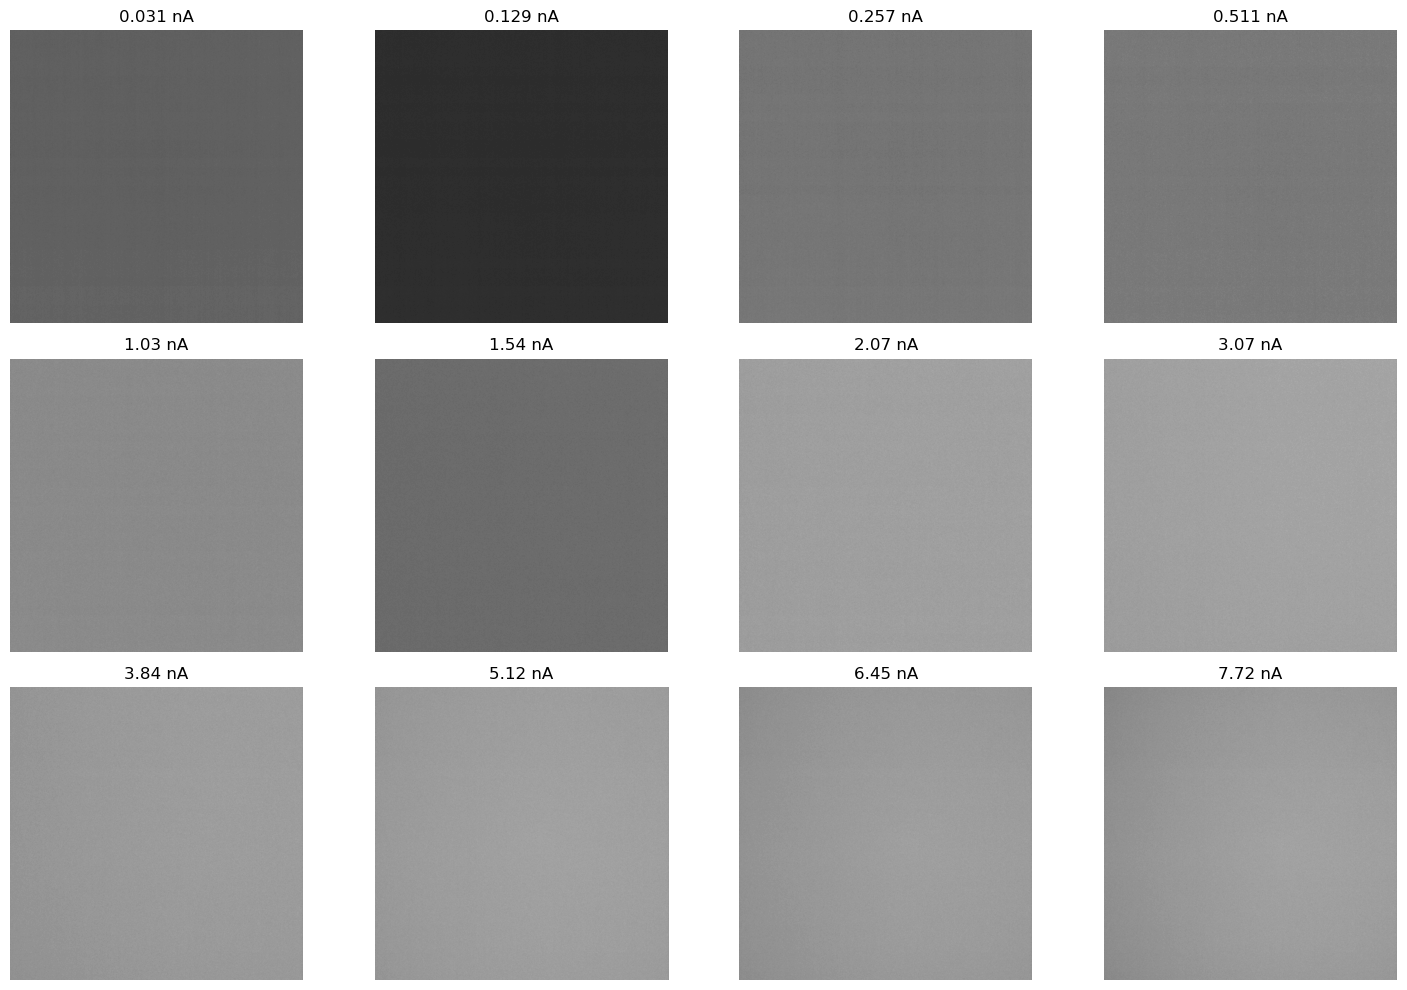

In [5]:
fig, axs = plt.subplots(rows, cols, figsize=(15, 10))  # Adjust size as needed

for i, ax in enumerate(axs.flat):
    if i < num_images:
        im = ax.imshow(gain_images[i], cmap='gray')  # Assuming grayscale images
        ax.set_title(f'{currents[i]} nA')
        ax.axis('off')
    else:
        ax.axis('off')  # Hide unused subplots

# Add a color bar
#fig.colorbar(im, ax=axs.ravel().tolist(), orientation='horizontal', pad=0.02)

plt.tight_layout()
plt.show()

In [ ]:
norm = Normalize(vmin=min(currents), vmax=max(currents[2:]))
colors = viridis(norm(currents[2:]))
fig, ax = plt.subplots()

for i, gain_image in enumerate(gain_images[2:]):
    ax.hist(gain_image.mean(axis = 0), color=colors[i])

ax.set_title('Distribuição dos valores dos pixels em relação à média (gain image)')
ax.set_xlabel('Valor do pixel normalizado')
ax.set_ylabel('Frequência')

# Adding the color bar
cbar = fig.colorbar(sm, ax=ax, label='Current (nA)') 

ax.legend()
plt.show()

In [ ]:
m,b = np.polyfit(currents, mean_scalar, 1)
poly1d_fn = np.poly1d((m,b)) 

mean_arrays = np.array(mean_arrays)
plt.scatter(currents, mean_scalar, label = "Pixel linearity")
plt.plot(currents, poly1d_fn(currents), '--k', label = f'Fitted line: y = {m:.2f}x + {b:.2f}')
plt.xlabel("Current (nA)")
plt.ylabel("Counts")
plt.legend()
plt.show()